# 企业级客户流失预测项目
## Customer Churn Prediction - End-to-End ML Pipeline

### 项目背景
客户流失（Customer Churn）是指客户停止使用公司的产品或服务。对于电信、金融、SaaS等行业，客户流失率直接影响企业收入和增长。

**业务价值：**
- 获取新客户的成本是留住老客户的5-25倍
- 提前识别高风险客户，采取挽留措施
- 优化营销策略，提高客户生命周期价值（CLV）

### 项目目标
构建一个机器学习模型，预测哪些客户可能在未来流失，并分析影响流失的关键因素。

### 数据集
使用Telco Customer Churn数据集（Kaggle），包含7043条客户记录，21个特征：
- **客户信息**：性别、年龄段、是否有伴侣/家属
- **服务信息**：电话服务、网络服务、在线安全、技术支持等
- **合同信息**：合同类型、支付方式、账单方式
- **财务信息**：月费用、总费用
- **目标变量**：Churn（是否流失）

### 技术栈
- **数据处理**: Pandas, NumPy
- **可视化**: Matplotlib, Seaborn
- **机器学习**: Scikit-learn, XGBoost, LightGBM
- **模型解释**: SHAP
- **类别平衡**: SMOTE, 类别权重

---

## 1. 环境设置与数据获取

### 1.1 导入必要的库

In [2]:
# 数据处理
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习 - 数据预处理
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 机器学习 - 模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 机器学习 - 评估指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# 类别不平衡处理
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# 模型保存
import joblib
import pickle

# 设置随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ 环境设置完成")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")

✅ 环境设置完成
Pandas版本: 2.0.3
NumPy版本: 1.24.3


### 1.2 下载数据集

**数据来源**: Kaggle - Telco Customer Churn

**下载方式**：
1. **使用Kaggle API（推荐）**:
```bash
# 安装kaggle
pip install kaggle

# 配置API密钥（从Kaggle账户下载kaggle.json）
# 放置在 ~/.kaggle/kaggle.json (Linux/Mac) 或 C:\Users\<username>\.kaggle\kaggle.json (Windows)

# 下载数据集
kaggle datasets download -d blastchar/telco-customer-churn
unzip telco-customer-churn.zip
```

2. **手动下载**:
   - 访问: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
   - 点击Download下载WA_Fn-UseC_-Telco-Customer-Churn.csv
   - 将文件放在当前目录

3. **使用示例数据**（如果暂时无法下载）:
   - 下方代码会尝试加载数据，如果失败会提供替代方案

In [5]:
# 尝试加载数据集
data_path = './data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(data_path)
    print("✅ 数据集加载成功！")
except FileNotFoundError:
    print("❌ 未找到数据文件，请按照上面的说明下载数据集")
    print("\n尝试从在线URL加载...")
    try:
        # 备用在线数据源
        url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
        df = pd.read_csv(url)
        print("✅ 从在线源加载成功！")
    except Exception as e:
        print(f"加载失败: {e}")
        print("\n请手动下载数据集后重新运行此单元格")
        raise

# 显示基本信息
print(f"\n数据集形状: {df.shape}")
print(f"行数: {df.shape[0]:,}")
print(f"列数: {df.shape[1]}")

✅ 数据集加载成功！

数据集形状: (7043, 21)
行数: 7,043
列数: 21


## 2. 数据探索与理解（EDA）

### 2.1 数据概览

In [6]:
# 查看前几行数据
print("=" * 80)
print("前5行数据:")
print("=" * 80)
display(df.head())

# 查看数据信息
print("\n" + "=" * 80)
print("数据集信息:")
print("=" * 80)
df.info()

# 查看列名
print("\n" + "=" * 80)
print("所有列名:")
print("=" * 80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

前5行数据:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   

In [7]:
# 分析数据类型
print("数据类型统计:")
print(df.dtypes.value_counts())

# 区分数值型和分类型特征
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# 移除目标变量和ID列
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')
if 'customerID' in categorical_features:
    categorical_features.remove('customerID')

print(f"\n数值型特征 ({len(numerical_features)}个): {numerical_features}")
print(f"\n分类型特征 ({len(categorical_features)}个): {categorical_features}")

数据类型统计:
object     18
int64       2
float64     1
Name: count, dtype: int64

数值型特征 (3个): ['SeniorCitizen', 'tenure', 'MonthlyCharges']

分类型特征 (16个): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


### 2.2 缺失值分析

In [8]:
# 检查缺失值
missing_stats = pd.DataFrame({
    '缺失数量': df.isnull().sum(),
    '缺失比例': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['缺失数量'] > 0].sort_values('缺失数量', ascending=False)

if len(missing_stats) > 0:
    print("存在缺失值的列:")
    print(missing_stats)
else:
    print("✅ 数据集中没有缺失值")

# 检查空字符串或空格
print("\n检查空字符串...")
for col in categorical_features:
    empty_count = (df[col].str.strip() == '').sum()
    if empty_count > 0:
        print(f"{col}: {empty_count}个空字符串")

✅ 数据集中没有缺失值

检查空字符串...
TotalCharges: 11个空字符串


### 2.3 目标变量分析

目标变量(Churn)分布:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

比例:
Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64


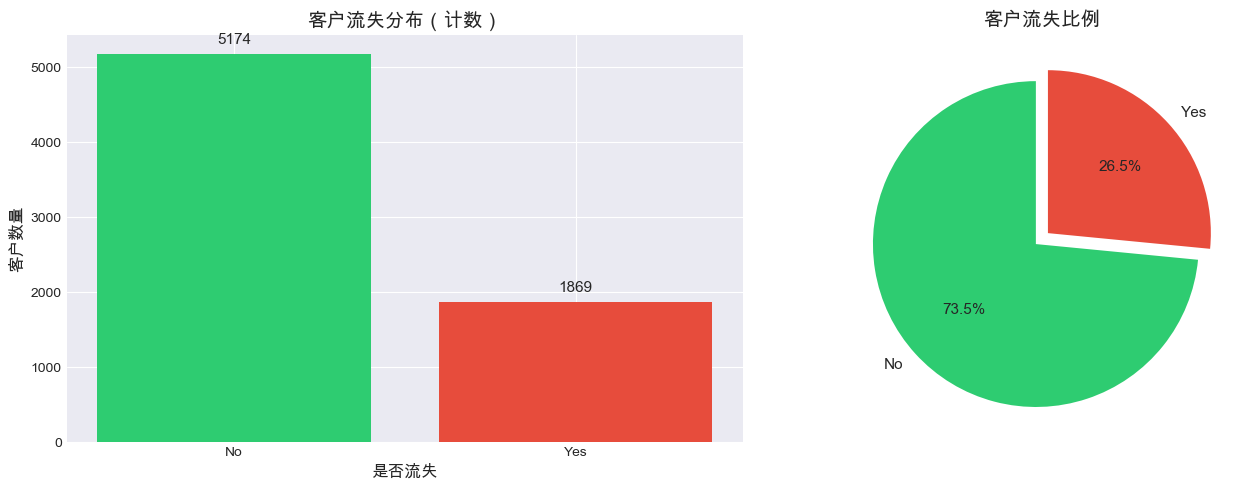


⚠️ 类别不平衡比例: 2.77:1 (未流失:流失)
建议: 需要处理类别不平衡问题（使用SMOTE、类别权重等）


In [9]:
# 目标变量分布
print("目标变量(Churn)分布:")
print(df['Churn'].value_counts())
print("\n比例:")
churn_pct = df['Churn'].value_counts(normalize=True) * 100
print(churn_pct.round(2))

# 可视化目标变量分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 计数图
churn_counts = df['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('客户流失分布（计数）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('是否流失', fontsize=12)
axes[0].set_ylabel('客户数量', fontsize=12)
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 饼图
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('客户流失比例', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 计算类别不平衡比例
churn_ratio = churn_counts['No'] / churn_counts['Yes']
print(f"\n⚠️ 类别不平衡比例: {churn_ratio:.2f}:1 (未流失:流失)")
if churn_ratio > 2:
    print("建议: 需要处理类别不平衡问题（使用SMOTE、类别权重等）")

### 2.4 数值型特征分析

数值型特征统计:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.16,0.37,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.37,24.56,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.76,30.09,18.25,35.5,70.35,89.85,118.75


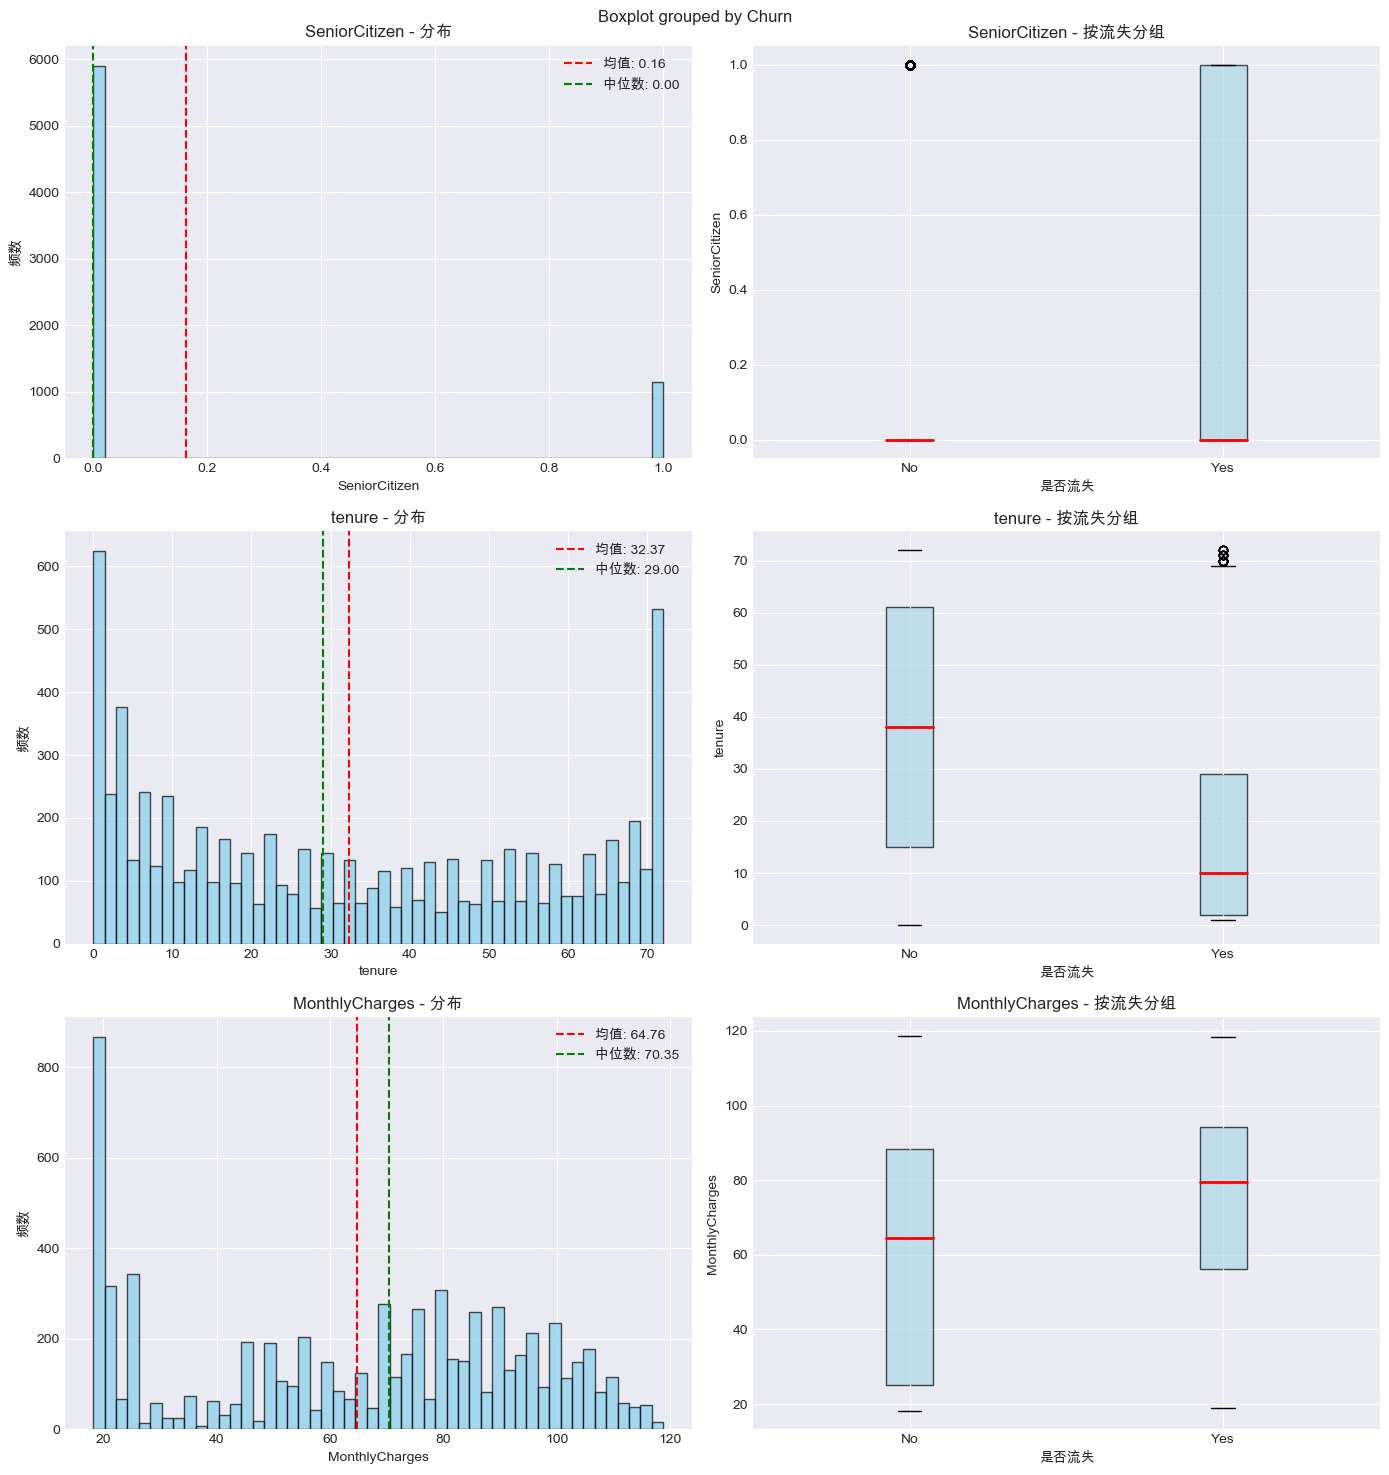

In [10]:
# 数值型特征统计描述
print("数值型特征统计:")
display(df[numerical_features].describe().T.round(2))

# 可视化数值型特征分布
n_numerical = len(numerical_features)
fig, axes = plt.subplots(n_numerical, 2, figsize=(14, 5*n_numerical))
if n_numerical == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(numerical_features):
    # 直方图
    axes[i, 0].hist(df[col].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'{col} - 分布', fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=10)
    axes[i, 0].set_ylabel('频数', fontsize=10)
    axes[i, 0].axvline(df[col].mean(), color='red', linestyle='--', label=f'均值: {df[col].mean():.2f}')
    axes[i, 0].axvline(df[col].median(), color='green', linestyle='--', label=f'中位数: {df[col].median():.2f}')
    axes[i, 0].legend()
    
    # 箱线图（按流失分组）
    df_plot = df[[col, 'Churn']].dropna()
    df_plot.boxplot(column=col, by='Churn', ax=axes[i, 1], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[i, 1].set_title(f'{col} - 按流失分组', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('是否流失', fontsize=10)
    axes[i, 1].set_ylabel(col, fontsize=10)
    plt.sca(axes[i, 1])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.tight_layout()
plt.show()

### 2.5 分类型特征分析

In [11]:
# 分类型特征统计
print("分类型特征唯一值数量:")
for col in categorical_features:
    unique_count = df[col].nunique()
    print(f"{col:30s}: {unique_count:3d} 个唯一值")

# 查看每个分类特征的值分布
print("\n各分类特征值分布:")
for col in categorical_features:
    print(f"\n{col}:")
    print(df[col].value_counts())

分类型特征唯一值数量:
gender                        :   2 个唯一值
Partner                       :   2 个唯一值
Dependents                    :   2 个唯一值
PhoneService                  :   2 个唯一值
MultipleLines                 :   3 个唯一值
InternetService               :   3 个唯一值
OnlineSecurity                :   3 个唯一值
OnlineBackup                  :   3 个唯一值
DeviceProtection              :   3 个唯一值
TechSupport                   :   3 个唯一值
StreamingTV                   :   3 个唯一值
StreamingMovies               :   3 个唯一值
Contract                      :   3 个唯一值
PaperlessBilling              :   2 个唯一值
PaymentMethod                 :   4 个唯一值
TotalCharges                  : 6531 个唯一值

各分类特征值分布:

gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines:
MultipleLine

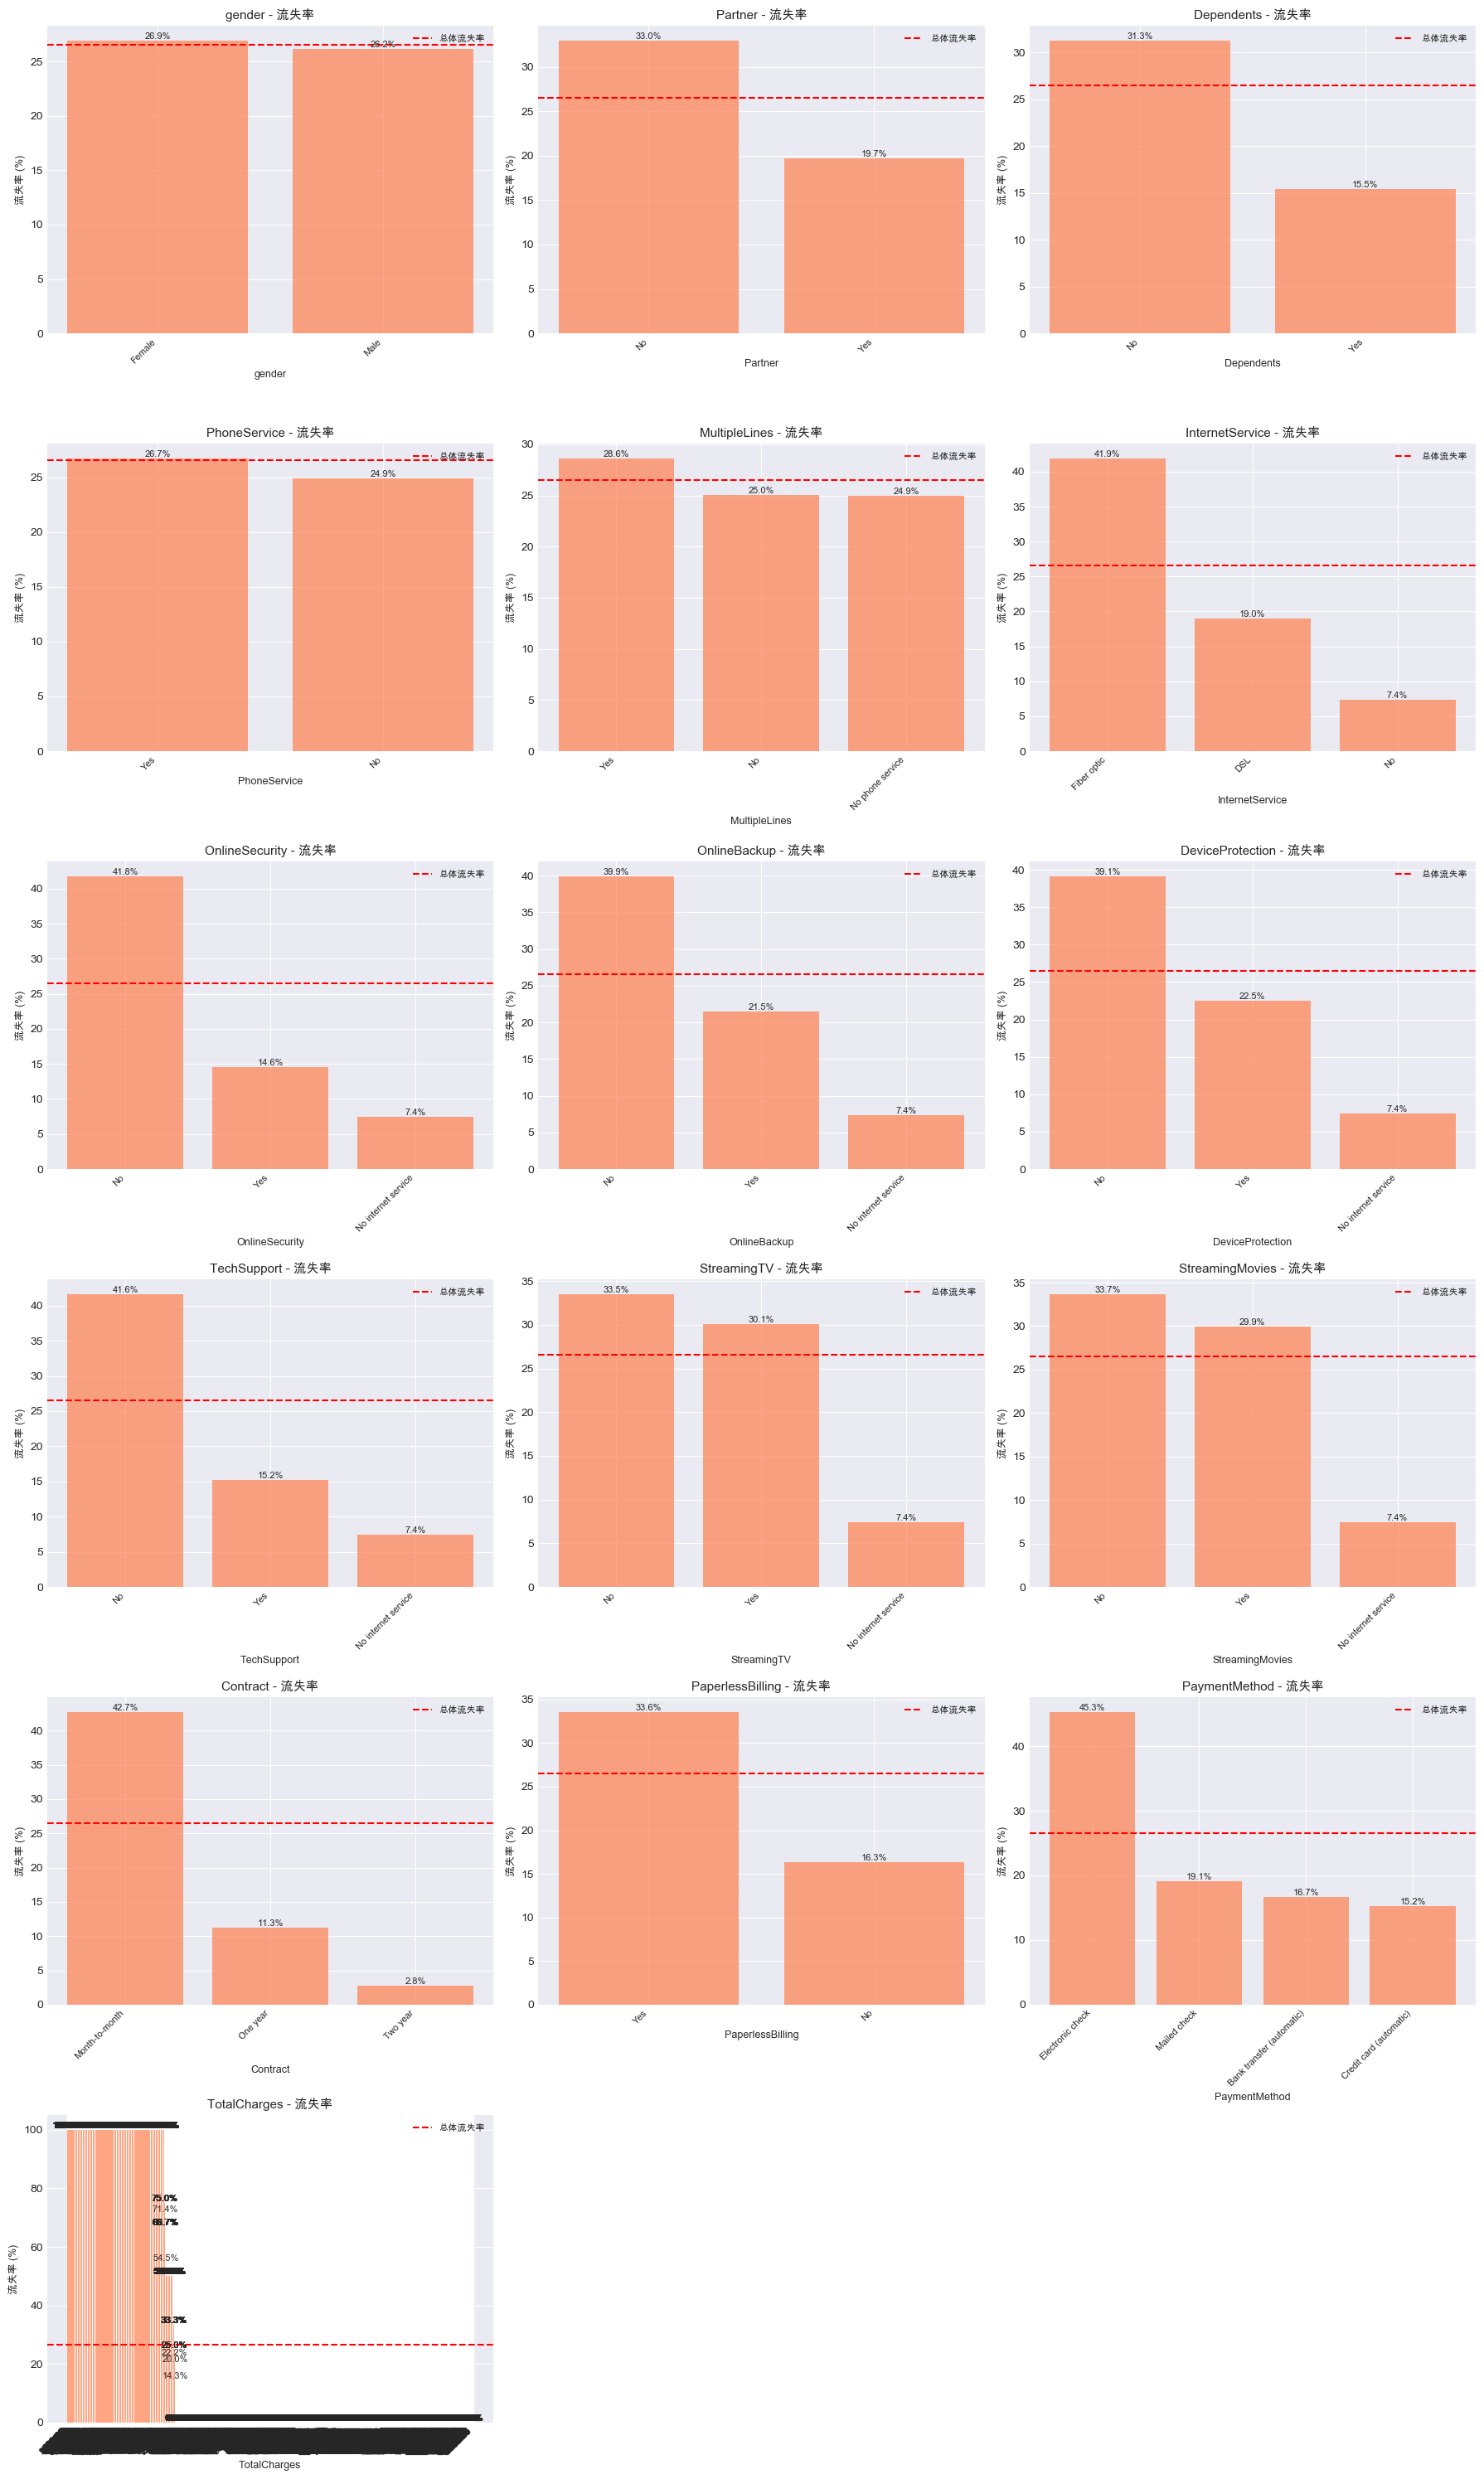

In [16]:
# 可视化分类特征与流失的关系
n_categorical = len(categorical_features)
n_cols = 3
n_rows = (n_categorical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_categorical > 1 else [axes]

for i, col in enumerate(categorical_features):
    # 计算每个类别的流失率
    churn_rate = df.groupby(col)['Churn'].apply(lambda x: (x=='Yes').sum() / len(x) * 100)
    churn_rate = churn_rate.sort_values(ascending=False)
    
    # 绘制柱状图
    bars = axes[i].bar(range(len(churn_rate)), churn_rate.values, color='coral', alpha=0.7)
    axes[i].set_title(f'{col} - 流失率', fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=9)
    axes[i].set_ylabel('流失率 (%)', fontsize=9)
    axes[i].set_xticks(range(len(churn_rate)))
    axes[i].set_xticklabels(churn_rate.index, rotation=45, ha='right', fontsize=8)
    axes[i].axhline(y=df[df['Churn']=='Yes'].shape[0]/len(df)*100, color='red', 
                    linestyle='--', label='总体流失率', linewidth=1.5)
    axes[i].legend(fontsize=8)
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 隐藏多余的子图
for i in range(n_categorical, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 2.6 相关性分析

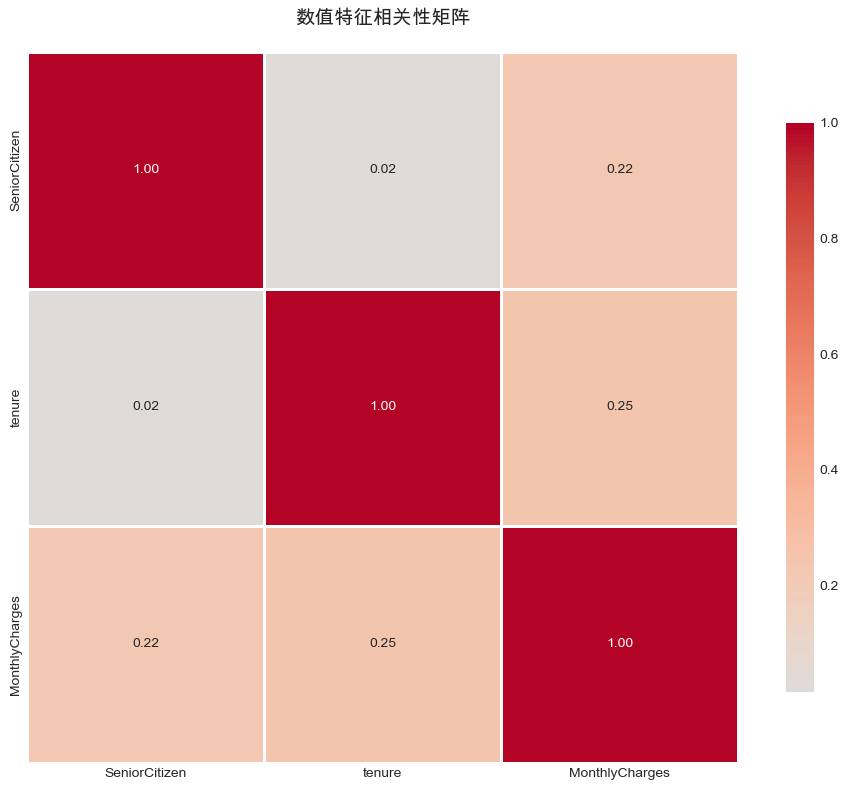


高相关性特征对 (|相关系数| > 0.7):
未发现高相关性特征对


In [17]:
# 数值特征相关性矩阵
if len(numerical_features) > 0:
    corr_matrix = df[numerical_features].corr()
    
    # 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('数值特征相关性矩阵', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 找出高相关性特征对
    print("\n高相关性特征对 (|相关系数| > 0.7):")
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr:
        for feat1, feat2, corr_val in high_corr:
            print(f"{feat1} <-> {feat2}: {corr_val:.3f}")
    else:
        print("未发现高相关性特征对")

### 2.7 EDA总结

基于以上分析，总结主要发现：

1. **数据质量**
   - 检查缺失值情况
   - 检查异常值
   - 检查数据类型是否正确

2. **目标变量**
   - 流失率
   - 类别是否平衡

3. **特征洞察**
   - 哪些特征与流失相关性强
   - 是否存在多重共线性
   - 是否需要特征工程

4. **下一步行动**
   - 数据清洗策略
   - 特征工程计划
   - 模型选择建议

## 3. 数据预处理

### 3.1 数据清洗

In [18]:
# 创建数据副本
df_clean = df.copy()

print("开始数据清洗...")
print(f"原始数据: {df_clean.shape}")

# 1. 删除customerID列（无预测价值）
if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop('customerID', axis=1)
    print("✅ 已删除customerID列")

# 2. 处理TotalCharges列（可能包含空格字符串）
if 'TotalCharges' in df_clean.columns:
    # 检查是否为object类型
    if df_clean['TotalCharges'].dtype == 'object':
        print("\n处理TotalCharges列...")
        # 转换为数值，空格转为NaN
        df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
        
        # 检查转换后的缺失值
        missing_total_charges = df_clean['TotalCharges'].isnull().sum()
        if missing_total_charges > 0:
            print(f"发现 {missing_total_charges} 个缺失值")
            
            # 分析缺失值情况
            missing_rows = df_clean[df_clean['TotalCharges'].isnull()]
            print(f"这些客户的tenure: {missing_rows['tenure'].value_counts().to_dict()}")
            
            # 用MonthlyCharges填充（新客户的TotalCharges应该等于MonthlyCharges）
            df_clean.loc[df_clean['TotalCharges'].isnull(), 'TotalCharges'] = \
                df_clean.loc[df_clean['TotalCharges'].isnull(), 'MonthlyCharges']
            print(f"✅ 已用MonthlyCharges填充TotalCharges的缺失值")

# 3. 检查并处理其他缺失值
missing_after = df_clean.isnull().sum()
if missing_after.sum() > 0:
    print("\n剩余缺失值:")
    print(missing_after[missing_after > 0])
else:
    print("\n✅ 无缺失值")

# 4. 处理异常值（基于业务逻辑）
# 例如：tenure=0但TotalCharges>0的情况
if 'tenure' in df_clean.columns and 'TotalCharges' in df_clean.columns:
    anomaly = df_clean[(df_clean['tenure'] == 0) & (df_clean['TotalCharges'] > 0)]
    if len(anomaly) > 0:
        print(f"\n⚠️ 发现 {len(anomaly)} 个异常记录: tenure=0 但 TotalCharges>0")
        # 可以选择删除或修正

print(f"\n清洗后数据: {df_clean.shape}")
print("✅ 数据清洗完成")

开始数据清洗...
原始数据: (7043, 21)
✅ 已删除customerID列

处理TotalCharges列...
发现 11 个缺失值
这些客户的tenure: {0: 11}
✅ 已用MonthlyCharges填充TotalCharges的缺失值

✅ 无缺失值

⚠️ 发现 11 个异常记录: tenure=0 但 TotalCharges>0

清洗后数据: (7043, 20)
✅ 数据清洗完成


### 3.2 特征编码

In [19]:
# 创建编码后的数据副本
df_encoded = df_clean.copy()

print("开始特征编码...\n")

# 1. 编码目标变量
print("1. 编码目标变量 Churn")
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})
print(f"   Yes->1, No->0")
print(f"   流失客户: {df_encoded['Churn'].sum()}")

# 2. 识别二值分类特征（只有两个唯一值）
binary_features = []
for col in df_encoded.select_dtypes(include='object').columns:
    if df_encoded[col].nunique() == 2:
        binary_features.append(col)

print(f"\n2. 二值特征 Label Encoding ({len(binary_features)}个)")
for col in binary_features:
    unique_vals = df_encoded[col].unique()
    print(f"   {col:20s}: {unique_vals}")
    # 对于Yes/No类型，统一映射
    if 'Yes' in unique_vals and 'No' in unique_vals:
        df_encoded[col] = df_encoded[col].map({'No': 0, 'Yes': 1})
    else:
        # 其他二值特征用LabelEncoder
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        print(f"      映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 3. 多分类特征 One-Hot Encoding
multi_categorical = [col for col in df_encoded.select_dtypes(include='object').columns 
                     if col not in binary_features]

print(f"\n3. 多分类特征 One-Hot Encoding ({len(multi_categorical)}个)")
if multi_categorical:
    for col in multi_categorical:
        print(f"   {col:20s}: {df_encoded[col].unique()}")
    
    # 执行One-Hot编码
    df_encoded = pd.get_dummies(df_encoded, columns=multi_categorical, drop_first=True)
    print(f"\n✅ One-Hot编码完成")
    print(f"   新增特征数: {len(df_encoded.columns) - len(df_clean.columns)}")
else:
    print("   无多分类特征")

print(f"\n编码后数据形状: {df_encoded.shape}")
print(f"特征数量: {df_encoded.shape[1] - 1}")
print("✅ 特征编码完成")

开始特征编码...

1. 编码目标变量 Churn
   Yes->1, No->0
   流失客户: 1869

2. 二值特征 Label Encoding (5个)
   gender              : ['Female' 'Male']
      映射: {'Female': 0, 'Male': 1}
   Partner             : ['Yes' 'No']
   Dependents          : ['No' 'Yes']
   PhoneService        : ['No' 'Yes']
   PaperlessBilling    : ['Yes' 'No']

3. 多分类特征 One-Hot Encoding (10个)
   MultipleLines       : ['No phone service' 'No' 'Yes']
   InternetService     : ['DSL' 'Fiber optic' 'No']
   OnlineSecurity      : ['No' 'Yes' 'No internet service']
   OnlineBackup        : ['Yes' 'No' 'No internet service']
   DeviceProtection    : ['No' 'Yes' 'No internet service']
   TechSupport         : ['No' 'Yes' 'No internet service']
   StreamingTV         : ['No' 'Yes' 'No internet service']
   StreamingMovies     : ['No' 'Yes' 'No internet service']
   Contract            : ['Month-to-month' 'One year' 'Two year']
   PaymentMethod       : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

In [20]:
# 查看编码后的数据
print("编码后的列名:")
for i, col in enumerate(df_encoded.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n前5行数据:")
display(df_encoded.head())

编码后的列名:
 1. gender
 2. SeniorCitizen
 3. Partner
 4. Dependents
 5. tenure
 6. PhoneService
 7. PaperlessBilling
 8. MonthlyCharges
 9. TotalCharges
10. Churn
11. MultipleLines_No phone service
12. MultipleLines_Yes
13. InternetService_Fiber optic
14. InternetService_No
15. OnlineSecurity_No internet service
16. OnlineSecurity_Yes
17. OnlineBackup_No internet service
18. OnlineBackup_Yes
19. DeviceProtection_No internet service
20. DeviceProtection_Yes
21. TechSupport_No internet service
22. TechSupport_Yes
23. StreamingTV_No internet service
24. StreamingTV_Yes
25. StreamingMovies_No internet service
26. StreamingMovies_Yes
27. Contract_One year
28. Contract_Two year
29. PaymentMethod_Credit card (automatic)
30. PaymentMethod_Electronic check
31. PaymentMethod_Mailed check

前5行数据:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


## 4. 特征工程

### 4.1 创建新特征

In [21]:
# 创建特征工程后的数据副本
df_fe = df_encoded.copy()

print("开始特征工程...\n")

# 1. 基于业务逻辑创建新特征
if 'tenure' in df_fe.columns and 'MonthlyCharges' in df_fe.columns:
    # 平均月费用（总费用/在网时长）
    df_fe['AvgMonthlyCharges'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)  # +1避免除0
    
    # 费用增长率
    df_fe['ChargeGrowthRate'] = (df_fe['MonthlyCharges'] - df_fe['AvgMonthlyCharges']) / (df_fe['AvgMonthlyCharges'] + 0.01)
    
    print("✅ 创建费用相关特征:")
    print("   - AvgMonthlyCharges (平均月费用)")
    print("   - ChargeGrowthRate (费用增长率)")

# 2. 在网时长分组
if 'tenure' in df_fe.columns:
    df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], 
                                   bins=[0, 12, 24, 48, 72], 
                                   labels=['0-1年', '1-2年', '2-4年', '4年以上'])
    # One-Hot编码
    df_fe = pd.get_dummies(df_fe, columns=['TenureGroup'], drop_first=True)
    print("\n✅ 创建在网时长分组特征")

# 3. 服务数量统计（如果有相关列）
service_cols = [col for col in df_fe.columns if 'Service' in col or 
                col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies']]
if service_cols:
    # 假设这些列已经是0/1编码
    df_fe['TotalServices'] = df_fe[service_cols].sum(axis=1)
    print(f"\n✅ 创建服务数量特征 (基于{len(service_cols)}个服务列)")

# 4. 合同与支付方式交互特征（示例）
# 根据实际编码后的列名调整
contract_cols = [col for col in df_fe.columns if 'Contract' in col]
payment_cols = [col for col in df_fe.columns if 'PaymentMethod' in col]
if contract_cols and payment_cols:
    print(f"\n发现 {len(contract_cols)} 个合同类型列, {len(payment_cols)} 个支付方式列")
    print("可以创建交互特征（根据需要）")

print(f"\n特征工程后数据形状: {df_fe.shape}")
print(f"新增特征数: {df_fe.shape[1] - df_encoded.shape[1]}")
print("✅ 特征工程完成")

开始特征工程...

✅ 创建费用相关特征:
   - AvgMonthlyCharges (平均月费用)
   - ChargeGrowthRate (费用增长率)

✅ 创建在网时长分组特征

✅ 创建服务数量特征 (基于3个服务列)

发现 2 个合同类型列, 3 个支付方式列
可以创建交互特征（根据需要）

特征工程后数据形状: (7043, 37)
新增特征数: 6
✅ 特征工程完成


### 4.2 特征选择

训练随机森林进行特征重要性分析...

Top 20 重要特征:


,Feature,Importance
31,ChargeGrowthRate,0.140498
8,TotalCharges,0.125234
7,MonthlyCharges,0.112597
30,AvgMonthlyCharges,0.110593
4,tenure,0.109263
11,InternetService_Fiber optic,0.032530
28,PaymentMethod_Electronic check,0.032076
26,Contract_Two year,0.029321
0,gender,0.021262
6,PaperlessBilling,0.019868


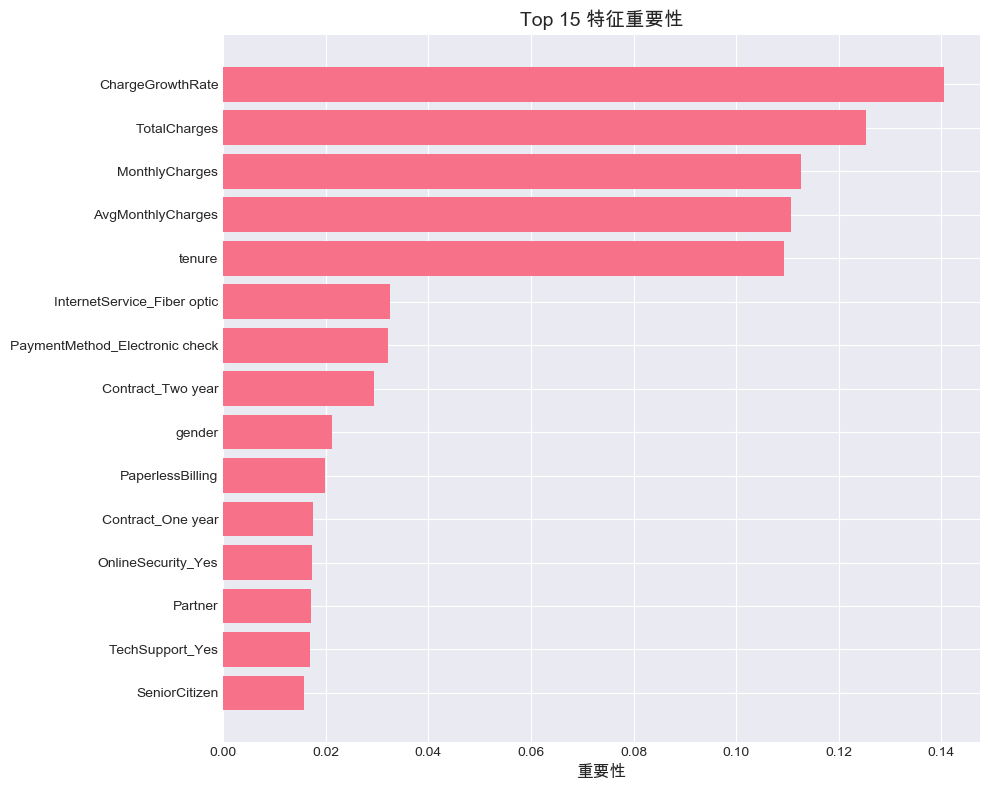


低重要性特征 (importance < 0.01): 11个
建议考虑移除: ['TenureGroup_2-4年', 'StreamingMovies_No internet service', 'TenureGroup_1-2年', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'DeviceProtection_No internet service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'InternetService_No', 'MultipleLines_No phone service']...


In [22]:
# 使用随机森林进行特征重要性分析
from sklearn.ensemble import RandomForestClassifier

# 分离特征和目标
X_temp = df_fe.drop('Churn', axis=1)
y_temp = df_fe['Churn']

print("训练随机森林进行特征重要性分析...")
rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# 获取特征重要性
feature_importance = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 重要特征:")
display(feature_importance.head(20))

# 可视化Top 15特征重要性
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'].values)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('重要性', fontsize=12)
plt.title('Top 15 特征重要性', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 可选：移除低重要性特征
importance_threshold = 0.01
low_importance_features = feature_importance[feature_importance['Importance'] < importance_threshold]['Feature'].tolist()
print(f"\n低重要性特征 (importance < {importance_threshold}): {len(low_importance_features)}个")
if low_importance_features:
    print(f"建议考虑移除: {low_importance_features[:10]}...")

## 5. 数据集划分与特征缩放

### 5.1 划分训练集、验证集、测试集

In [23]:
# 分离特征和目标
X = df_fe.drop('Churn', axis=1)
y = df_fe['Churn']

print(f"特征矩阵: {X.shape}")
print(f"目标变量: {y.shape}")
print(f"流失客户: {y.sum()} ({y.sum()/len(y)*100:.2f}%)")

# 第一次划分：分出测试集(20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 第二次划分：从剩余80%中分出验证集(20% of 80% = 16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_temp
)

print("\n数据集划分:")
print(f"训练集: {X_train.shape} - 流失率: {y_train.sum()/len(y_train)*100:.2f}%")
print(f"验证集: {X_val.shape} - 流失率: {y_val.sum()/len(y_val)*100:.2f}%")
print(f"测试集: {X_test.shape} - 流失率: {y_test.sum()/len(y_test)*100:.2f}%")
print("\n✅ 数据集划分完成")

特征矩阵: (7043, 36)
目标变量: (7043,)
流失客户: 1869 (26.54%)

数据集划分:
训练集: (4507, 36) - 流失率: 26.54%
验证集: (1127, 36) - 流失率: 26.53%
测试集: (1409, 36) - 流失率: 26.54%

✅ 数据集划分完成


### 5.2 特征缩放

In [24]:
# 标准化数值特征
scaler = StandardScaler()

# 仅对训练集fit，然后transform所有集合
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("特征缩放完成")
print(f"\n缩放前示例 (训练集前5行):")
display(X_train.head())
print(f"\n缩放后示例 (训练集前5行):")
display(X_train_scaled.head())
print("\n✅ 特征缩放完成")

特征缩放完成

缩放前示例 (训练集前5行):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthlyCharges,ChargeGrowthRate,TenureGroup_1-2年,TenureGroup_2-4年,TenureGroup_4年以上,TotalServices
6592,1,0,0,0,26,1,0,59.45,1507.00,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,55.814815,0.065118,False,True,False,1
464,1,1,1,0,72,1,1,116.05,8404.90,False,True,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,115.135616,0.007941,False,False,True,2
5420,1,0,1,0,70,1,0,114.30,8244.30,False,True,True,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,True,False,False,116.116901,-0.015646,False,False,True,2
629,1,1,1,0,49,1,0,90.05,4547.25,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,90.945000,-0.009840,False,False,True,2
431,0,0,1,1,72,0,1,65.20,4784.45,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,True,False,False,65.540411,-0.005193,False,False,True,0



缩放后示例 (训练集前5行):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgMonthlyCharges,ChargeGrowthRate,TenureGroup_1-2年,TenureGroup_2-4年,TenureGroup_4年以上,TotalServices
6592,0.992264,-0.439271,-0.966181,-0.654273,-0.255392,0.338772,-1.214501,-0.174760,-0.340610,-0.338772,-0.851374,-0.879609,-0.523683,-0.523683,-0.635305,-0.523683,-0.733996,-0.523683,-0.719381,-0.523683,1.562197,-0.523683,1.245831,-0.523683,-0.797455,1.977267,-0.564453,1.920913,-0.709815,-0.548723,-0.101849,-0.333986,-0.412729,1.860746,-0.681019,-0.814418
464,0.992264,2.276498,1.035003,-0.654273,1.610432,0.338772,0.823383,1.710993,2.686483,-0.338772,1.174572,1.136869,-0.523683,-0.523683,1.574047,-0.523683,1.362405,-0.523683,1.390085,-0.523683,1.562197,-0.523683,1.245831,-0.523683,1.253989,-0.505749,1.771626,-0.520586,-0.709815,-0.548723,1.846091,-0.530461,-0.412729,-0.537419,1.468388,0.670446
5420,0.992264,-0.439271,1.035003,-0.654273,1.529309,0.338772,-1.214501,1.652688,2.616005,-0.338772,1.174572,1.136869,-0.523683,-0.523683,1.574047,-0.523683,1.362405,-0.523683,1.390085,-0.523683,1.562197,-0.523683,1.245831,-0.523683,1.253989,-0.505749,1.771626,1.920913,-0.709815,-0.548723,1.878314,-0.611512,-0.412729,-0.537419,1.468388,0.670446
629,0.992264,2.276498,1.035003,-0.654273,0.677520,0.338772,-1.214501,0.844746,0.993581,-0.338772,1.174572,1.136869,-0.523683,-0.523683,-0.635305,-0.523683,1.362405,-0.523683,-0.719381,-0.523683,-0.640124,-0.523683,-0.802677,-0.523683,1.253989,-0.505749,-0.564453,1.920913,-0.709815,-0.548723,1.051734,-0.591562,-0.412729,-0.537419,1.468388,0.670446
431,-1.007796,-0.439271,1.035003,1.528413,1.610432,-2.951840,0.823383,0.016814,1.097675,2.951840,-0.851374,-0.879609,-0.523683,-0.523683,1.574047,-0.523683,1.362405,-0.523683,1.390085,-0.523683,1.562197,-0.523683,1.245831,-0.523683,1.253989,-0.505749,1.771626,1.920913,-0.709815,-0.548723,0.217514,-0.575594,-0.412729,-0.537419,1.468388,-2.299282



✅ 特征缩放完成


### 5.3 处理类别不平衡

处理类别不平衡...

原始训练集类别分布:
Churn
0    3311
1    1196
Name: count, dtype: int64
比例: {0: 0.735, 1: 0.265}

SMOTE后训练集类别分布:
Churn
0    3311
1    3311
Name: count, dtype: int64
比例: {0: 0.5, 1: 0.5}

训练集大小: (4507, 36) -> (6622, 36)
✅ 类别平衡处理完成


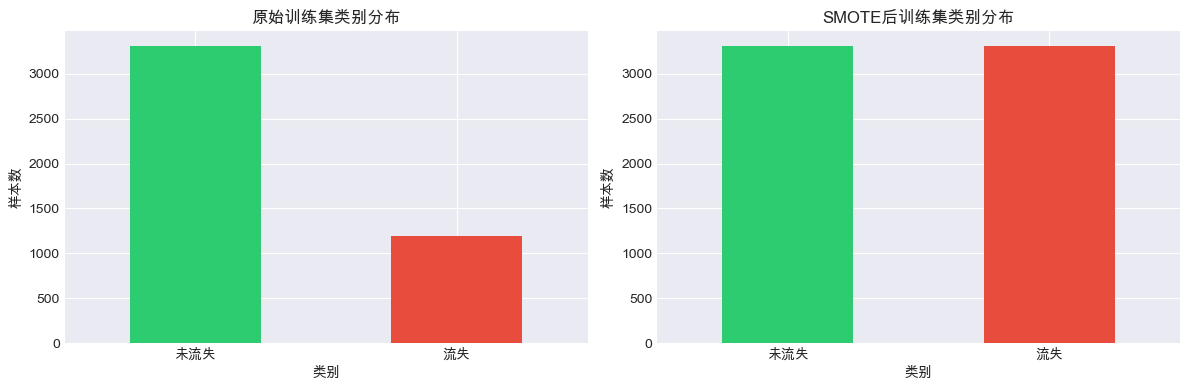

In [25]:
# 使用SMOTE进行过采样
print("处理类别不平衡...\n")
print(f"原始训练集类别分布:")
print(y_train.value_counts())
print(f"比例: {y_train.value_counts(normalize=True).round(3).to_dict()}")

# 应用SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nSMOTE后训练集类别分布:")
print(pd.Series(y_train_balanced).value_counts())
print(f"比例: {pd.Series(y_train_balanced).value_counts(normalize=True).round(3).to_dict()}")

print(f"\n训练集大小: {X_train_scaled.shape} -> {X_train_balanced.shape}")
print("✅ 类别平衡处理完成")

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 原始分布
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('原始训练集类别分布', fontsize=12, fontweight='bold')
axes[0].set_xlabel('类别', fontsize=10)
axes[0].set_ylabel('样本数', fontsize=10)
axes[0].set_xticklabels(['未流失', '流失'], rotation=0)

# SMOTE后分布
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('SMOTE后训练集类别分布', fontsize=12, fontweight='bold')
axes[1].set_xlabel('类别', fontsize=10)
axes[1].set_ylabel('样本数', fontsize=10)
axes[1].set_xticklabels(['未流失', '流失'], rotation=0)

plt.tight_layout()
plt.show()

---

## 📌 下一步

到此为止，我们已经完成:
1. ✅ 数据加载与探索
2. ✅ 数据清洗与预处理
3. ✅ 特征工程
4. ✅ 数据集划分与缩放
5. ✅ 类别不平衡处理

接下来将进行:
- **模型训练**: 训练多个分类模型
- **模型评估**: 使用ROC-AUC、精确率、召回率等指标
- **模型优化**: 超参数调优
- **模型解释**: 特征重要性、SHAP值
- **模型部署**: 保存模型，创建预测接口

**继续执行下面的单元格来训练模型...**

## 6. 模型训练

### 6.1 定义评估函数

In [26]:
# 定义模型评估函数
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    评估模型性能
    
    参数:
        model: 训练好的模型
        X_train, y_train: 训练集
        X_val, y_val: 验证集
        model_name: 模型名称
    
    返回:
        dict: 包含各项评估指标的字典
    """
    # 训练集预测
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # 验证集预测
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # 计算指标
    results = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Val_Accuracy': accuracy_score(y_val, y_val_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Val_Precision': precision_score(y_val, y_val_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Val_Recall': recall_score(y_val, y_val_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Val_F1': f1_score(y_val, y_val_pred),
        'Train_ROC_AUC': roc_auc_score(y_train, y_train_pred_proba),
        'Val_ROC_AUC': roc_auc_score(y_val, y_val_pred_proba)
    }
    
    return results

def print_evaluation(results):
    """打印评估结果"""
    print(f"\n{'='*60}")
    print(f"模型: {results['Model']}")
    print(f"{'='*60}")
    print(f"{'指标':<20} {'训练集':>15} {'验证集':>15}")
    print(f"{'-'*60}")
    print(f"{'Accuracy':<20} {results['Train_Accuracy']:>15.4f} {results['Val_Accuracy']:>15.4f}")
    print(f"{'Precision':<20} {results['Train_Precision']:>15.4f} {results['Val_Precision']:>15.4f}")
    print(f"{'Recall':<20} {results['Train_Recall']:>15.4f} {results['Val_Recall']:>15.4f}")
    print(f"{'F1-Score':<20} {results['Train_F1']:>15.4f} {results['Val_F1']:>15.4f}")
    print(f"{'ROC-AUC':<20} {results['Train_ROC_AUC']:>15.4f} {results['Val_ROC_AUC']:>15.4f}")
    print(f"{'='*60}")

print("✅ 评估函数定义完成")

✅ 评估函数定义完成


### 6.2 训练基础模型

我们将训练以下几种模型进行对比：
1. **逻辑回归** (Logistic Regression)
2. **决策树** (Decision Tree)
3. **随机森林** (Random Forest)
4. **梯度提升树** (Gradient Boosting)
5. **XGBoost**
6. **LightGBM**

In [27]:
# 初始化模型字典
import time

models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=RANDOM_STATE, verbose=-1)
}

# 存储结果
all_results = []
trained_models = {}

print("开始训练模型...\n")
print("="*80)

for name, model in models.items():
    print(f"\n训练 {name}...")
    start_time = time.time()
    
    # 训练模型
    model.fit(X_train_balanced, y_train_balanced)
    
    # 评估模型
    results = evaluate_model(model, X_train_balanced, y_train_balanced, 
                            X_val_scaled, y_val, model_name=name)
    
    # 保存结果
    all_results.append(results)
    trained_models[name] = model
    
    # 计算训练时间
    training_time = time.time() - start_time
    
    # 打印结果
    print_evaluation(results)
    print(f"训练时间: {training_time:.2f}秒")

print("\n" + "="*80)
print("✅ 所有模型训练完成")

开始训练模型...


训练 Logistic Regression...

模型: Logistic Regression
指标                               训练集             验证集
------------------------------------------------------------
Accuracy                      0.7921          0.7613
Precision                     0.7648          0.5349
Recall                        0.8436          0.7692
F1-Score                      0.8022          0.6310
ROC-AUC                       0.8666          0.8526
训练时间: 0.04秒

训练 Decision Tree...

模型: Decision Tree
指标                               训练集             验证集
------------------------------------------------------------
Accuracy                      0.9988          0.7267
Precision                     0.9997          0.4870
Recall                        0.9979          0.5652
F1-Score                      0.9988          0.5232
ROC-AUC                       1.0000          0.6749
训练时间: 0.04秒

训练 Random Forest...

模型: Random Forest
指标                               训练集             验证集
----------------------

## 7. 模型评估与对比

### 7.1 对比所有模型性能

所有模型性能对比:


,Model,Train_Accuracy,Val_Accuracy,Train_Precision,Val_Precision,Train_Recall,Val_Recall,Train_F1,Val_F1,Train_ROC_AUC,Val_ROC_AUC
0,Logistic Regression,0.7921,0.7613,0.7648,0.5349,0.8436,0.7692,0.8022,0.6310,0.8666,0.8526
1,Decision Tree,0.9988,0.7267,0.9997,0.4870,0.9979,0.5652,0.9988,0.5232,1.0000,0.6749
2,Random Forest,0.9988,0.7888,0.9988,0.6063,0.9988,0.5819,0.9988,0.5939,1.0000,0.8251
3,Gradient Boosting,0.8677,0.8012,0.8567,0.6154,0.8831,0.6689,0.8697,0.6410,0.9454,0.8474
4,XGBoost,0.9710,0.7693,0.9646,0.5694,0.9780,0.5351,0.9712,0.5517,0.9959,0.8268
5,LightGBM,0.9292,0.7959,0.9262,0.6264,0.9326,0.5719,0.9294,0.5979,0.9840,0.8344



按验证集ROC-AUC排序:


,Model,Val_ROC_AUC,Val_F1,Val_Precision,Val_Recall
0,Logistic Regression,0.8526,0.6310,0.5349,0.7692
3,Gradient Boosting,0.8474,0.6410,0.6154,0.6689
5,LightGBM,0.8344,0.5979,0.6264,0.5719
4,XGBoost,0.8268,0.5517,0.5694,0.5351
2,Random Forest,0.8251,0.5939,0.6063,0.5819
1,Decision Tree,0.6749,0.5232,0.4870,0.5652


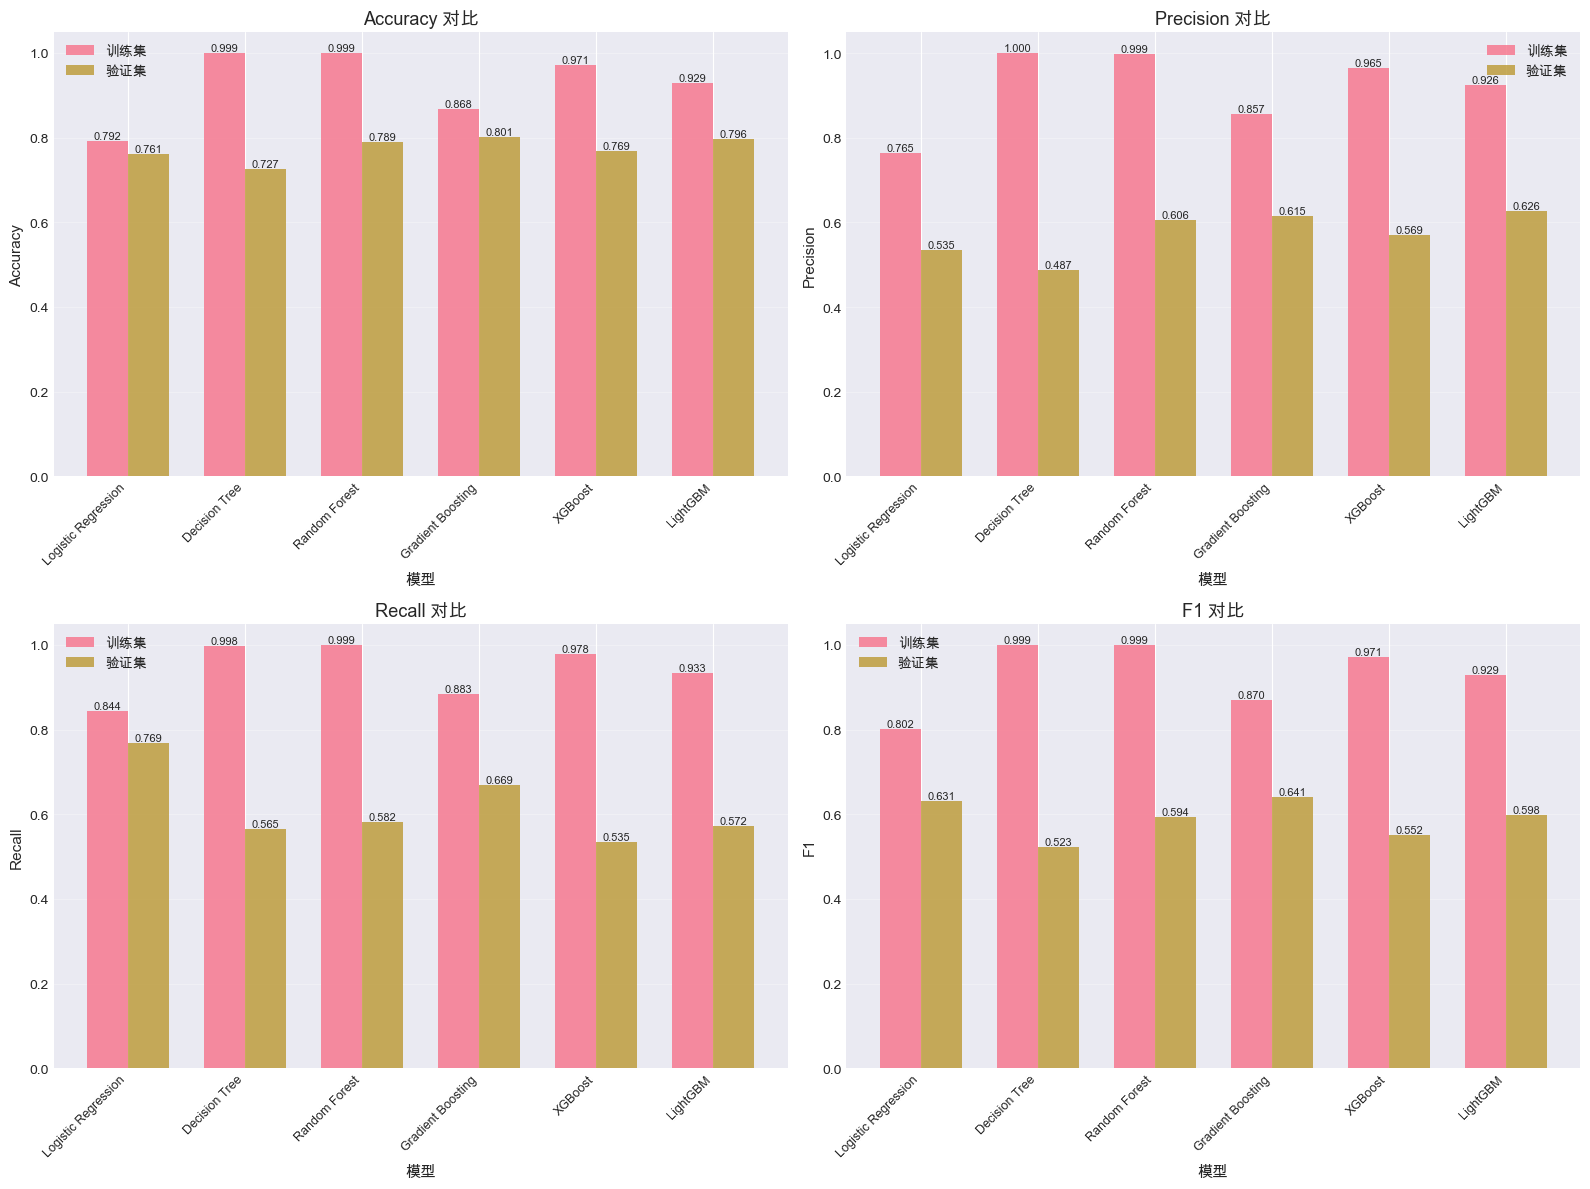

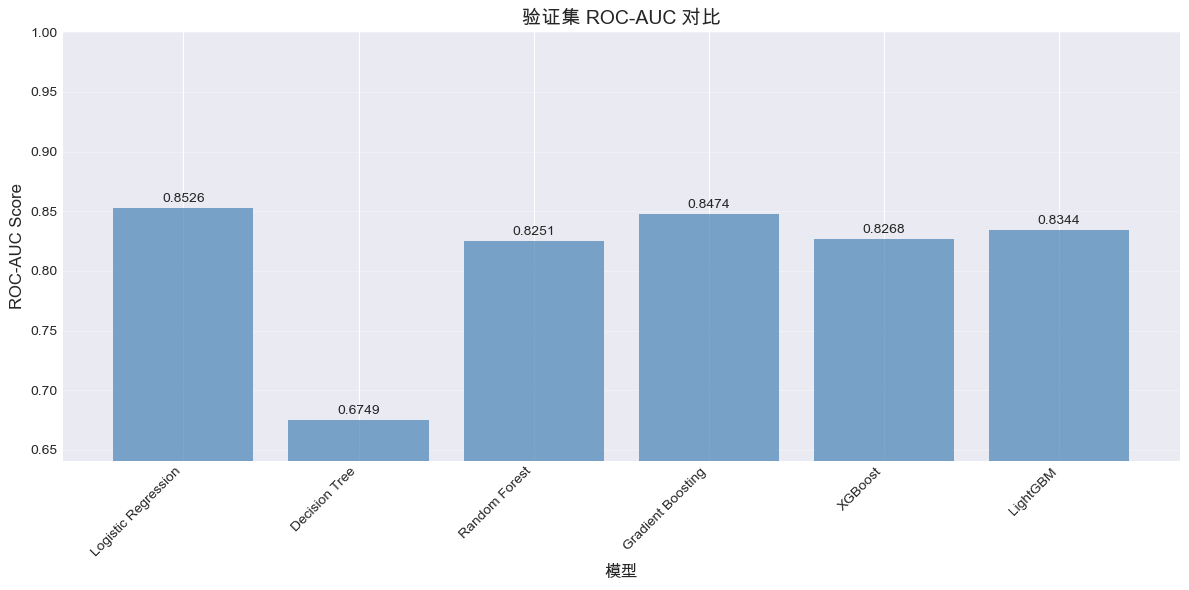


✅ 模型对比完成


In [28]:
# 创建结果对比表
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print("所有模型性能对比:")
print("="*100)
display(results_df)

# 按验证集ROC-AUC排序
results_sorted = results_df.sort_values('Val_ROC_AUC', ascending=False)
print("\n按验证集ROC-AUC排序:")
display(results_sorted[['Model', 'Val_ROC_AUC', 'Val_F1', 'Val_Precision', 'Val_Recall']])

# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
positions = [(0,0), (0,1), (1,0), (1,1)]

for metric, pos in zip(metrics, positions):
    ax = axes[pos]
    
    # 训练集和验证集数据
    train_col = f'Train_{metric}'
    val_col = f'Val_{metric}'
    
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df[train_col], width, label='训练集', alpha=0.8)
    bars2 = ax.bar(x + width/2, results_df[val_col], width, label='验证集', alpha=0.8)
    
    ax.set_xlabel('模型', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} 对比', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ROC-AUC单独可视化
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
plt.bar(x, results_df['Val_ROC_AUC'], color='steelblue', alpha=0.7)
plt.xlabel('模型', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('验证集 ROC-AUC 对比', fontsize=14, fontweight='bold')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.ylim(min(results_df['Val_ROC_AUC'])*0.95, 1.0)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['Val_ROC_AUC']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ 模型对比完成")

### 7.2 ROC曲线与AUC

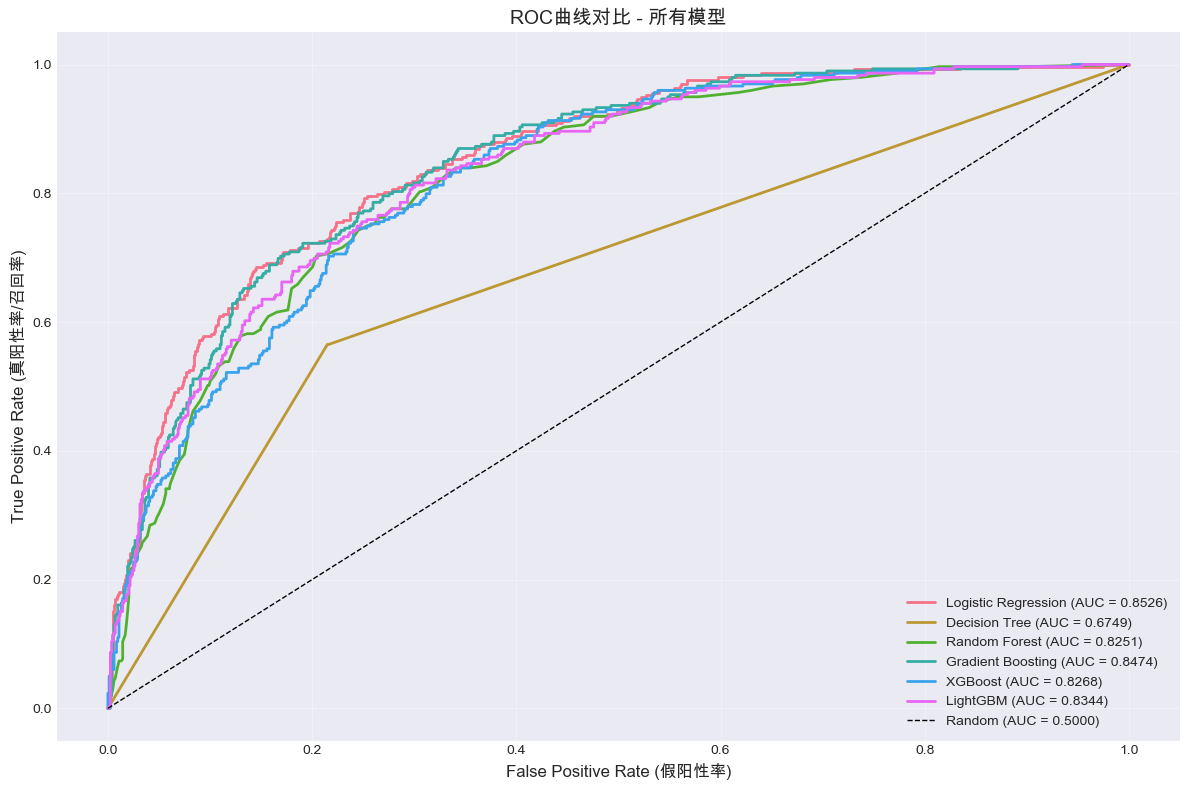

✅ ROC曲线绘制完成


In [29]:
# 绘制所有模型的ROC曲线
plt.figure(figsize=(12, 8))

for name, model in trained_models.items():
    # 预测概率
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 绘制
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate (假阳性率)', fontsize=12)
plt.ylabel('True Positive Rate (真阳性率/召回率)', fontsize=12)
plt.title('ROC曲线对比 - 所有模型', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ ROC曲线绘制完成")

### 7.3 混淆矩阵分析

选择最佳模型（基于验证集ROC-AUC）进行详细分析

最佳模型: Logistic Regression
验证集 ROC-AUC: 0.8526



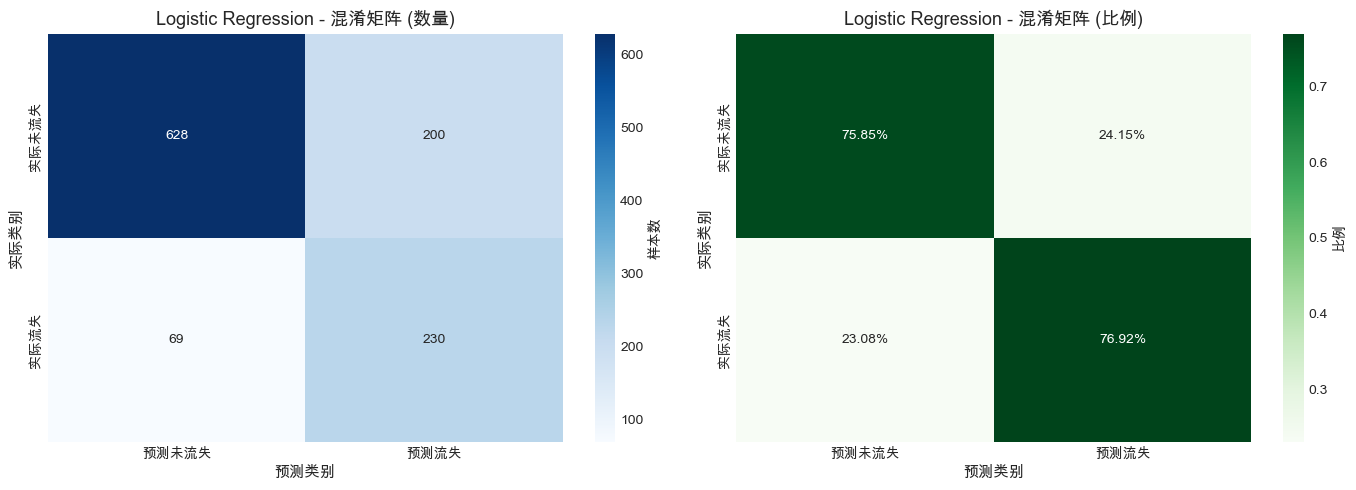


分类报告:
              precision    recall  f1-score   support

         未流失       0.90      0.76      0.82       828
          流失       0.53      0.77      0.63       299

    accuracy                           0.76      1127
   macro avg       0.72      0.76      0.73      1127
weighted avg       0.80      0.76      0.77      1127


混淆矩阵解读:
True Negatives (TN):    628 - 正确预测未流失
False Positives (FP):   200 - 错误预测为流失 (误报)
False Negatives (FN):    69 - 错误预测为未流失 (漏报)
True Positives (TP):    230 - 正确预测流失

业务影响:
- 误报率: 24.15% (将不流失客户误判为流失)
- 漏报率: 23.08% (将流失客户误判为不流失)

✅ 混淆矩阵分析完成


In [30]:
# 选择最佳模型
best_model_name = results_sorted.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"最佳模型: {best_model_name}")
print(f"验证集 ROC-AUC: {results_sorted.iloc[0]['Val_ROC_AUC']:.4f}\n")

# 预测
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# 混淆矩阵
cm = confusion_matrix(y_val, y_val_pred)

# 可视化混淆矩阵
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 数量混淆矩阵
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': '样本数'},
            xticklabels=['预测未流失', '预测流失'],
            yticklabels=['实际未流失', '实际流失'])
axes[0].set_title(f'{best_model_name} - 混淆矩阵 (数量)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('实际类别', fontsize=11)
axes[0].set_xlabel('预测类别', fontsize=11)

# 比例混淆矩阵
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            cbar_kws={'label': '比例'},
            xticklabels=['预测未流失', '预测流失'],
            yticklabels=['实际未流失', '实际流失'])
axes[1].set_title(f'{best_model_name} - 混淆矩阵 (比例)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('实际类别', fontsize=11)
axes[1].set_xlabel('预测类别', fontsize=11)

plt.tight_layout()
plt.show()

# 详细分类报告
print("\n分类报告:")
print("="*60)
print(classification_report(y_val, y_val_pred, target_names=['未流失', '流失']))

# 关键指标解读
tn, fp, fn, tp = cm.ravel()
print("\n混淆矩阵解读:")
print("="*60)
print(f"True Negatives (TN):  {tn:>5} - 正确预测未流失")
print(f"False Positives (FP): {fp:>5} - 错误预测为流失 (误报)")
print(f"False Negatives (FN): {fn:>5} - 错误预测为未流失 (漏报)")
print(f"True Positives (TP):  {tp:>5} - 正确预测流失")
print("\n业务影响:")
print(f"- 误报率: {fp/(fp+tn)*100:.2f}% (将不流失客户误判为流失)")
print(f"- 漏报率: {fn/(fn+tp)*100:.2f}% (将流失客户误判为不流失)")
print("\n✅ 混淆矩阵分析完成")

## 8. 模型优化

### 8.1 超参数调优（以最佳模型为例）

使用GridSearchCV或RandomizedSearchCV进行超参数调优

In [31]:
# 定义超参数搜索空间（以XGBoost或LightGBM为例）
print(f"对最佳模型 {best_model_name} 进行超参数调优...\n")

if 'XGBoost' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    base_model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False)
    
elif 'LightGBM' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    
elif 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    
else:
    # 对于其他模型，使用默认参数
    print(f"⚠️ {best_model_name} 暂不进行超参数调优，使用默认最佳模型")
    param_grid = None
    base_model = best_model

if param_grid:
    print(f"超参数搜索空间: {len(param_grid)} 个参数")
    print(f"使用RandomizedSearchCV进行调优 (更快)...\n")
    
    # 使用RandomizedSearchCV（比GridSearchCV快）
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=20,  # 随机尝试20组参数
        cv=3,  # 3折交叉验证
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    
    # 训练
    start_time = time.time()
    random_search.fit(X_train_balanced, y_train_balanced)
    training_time = time.time() - start_time
    
    print(f"\n✅ 调优完成，耗时: {training_time:.2f}秒")
    print(f"\n最佳参数:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\n最佳交叉验证ROC-AUC: {random_search.best_score_:.4f}")
    
    # 使用最佳模型
    optimized_model = random_search.best_estimator_
    
    # 评估优化后的模型
    optimized_results = evaluate_model(
        optimized_model, X_train_balanced, y_train_balanced,
        X_val_scaled, y_val, model_name=f"{best_model_name} (Optimized)"
    )
    
    print_evaluation(optimized_results)
    
    # 对比优化前后
    print("\n优化前后对比:")
    print("="*60)
    original_val_auc = results_sorted.iloc[0]['Val_ROC_AUC']
    optimized_val_auc = optimized_results['Val_ROC_AUC']
    improvement = (optimized_val_auc - original_val_auc) / original_val_auc * 100
    
    print(f"原始模型验证集 ROC-AUC: {original_val_auc:.4f}")
    print(f"优化模型验证集 ROC-AUC: {optimized_val_auc:.4f}")
    print(f"提升: {improvement:+.2f}%")
    
    # 使用优化后的模型作为最终模型
    if optimized_val_auc > original_val_auc:
        print("\n✅ 优化后模型性能更好，使用优化模型作为最终模型")
        final_model = optimized_model
        final_model_name = f"{best_model_name} (Optimized)"
    else:
        print("\n⚠️ 原始模型性能更好，保持使用原始模型")
        final_model = best_model
        final_model_name = best_model_name
else:
    final_model = best_model
    final_model_name = best_model_name
    print("✅ 使用原始最佳模型作为最终模型")

对最佳模型 Logistic Regression 进行超参数调优...

⚠️ Logistic Regression 暂不进行超参数调优，使用默认最佳模型
✅ 使用原始最佳模型作为最终模型


## 9. 模型解释

### 9.1 特征重要性分析

分析 Logistic Regression 的特征重要性...

Top 20 最重要特征 (按系数绝对值):


,Feature,Coefficient,Abs_Coefficient
7,MonthlyCharges,-1.781561,1.781561
26,Contract_Two year,-0.787166,0.787166
30,AvgMonthlyCharges,0.744848,0.744848
11,InternetService_Fiber optic,0.711769,0.711769
4,tenure,-0.596361,0.596361
31,ChargeGrowthRate,0.554772,0.554772
35,TotalServices,0.409624,0.409624
24,StreamingMovies_Yes,0.377306,0.377306
25,Contract_One year,-0.340761,0.340761
22,StreamingTV_Yes,0.335999,0.335999


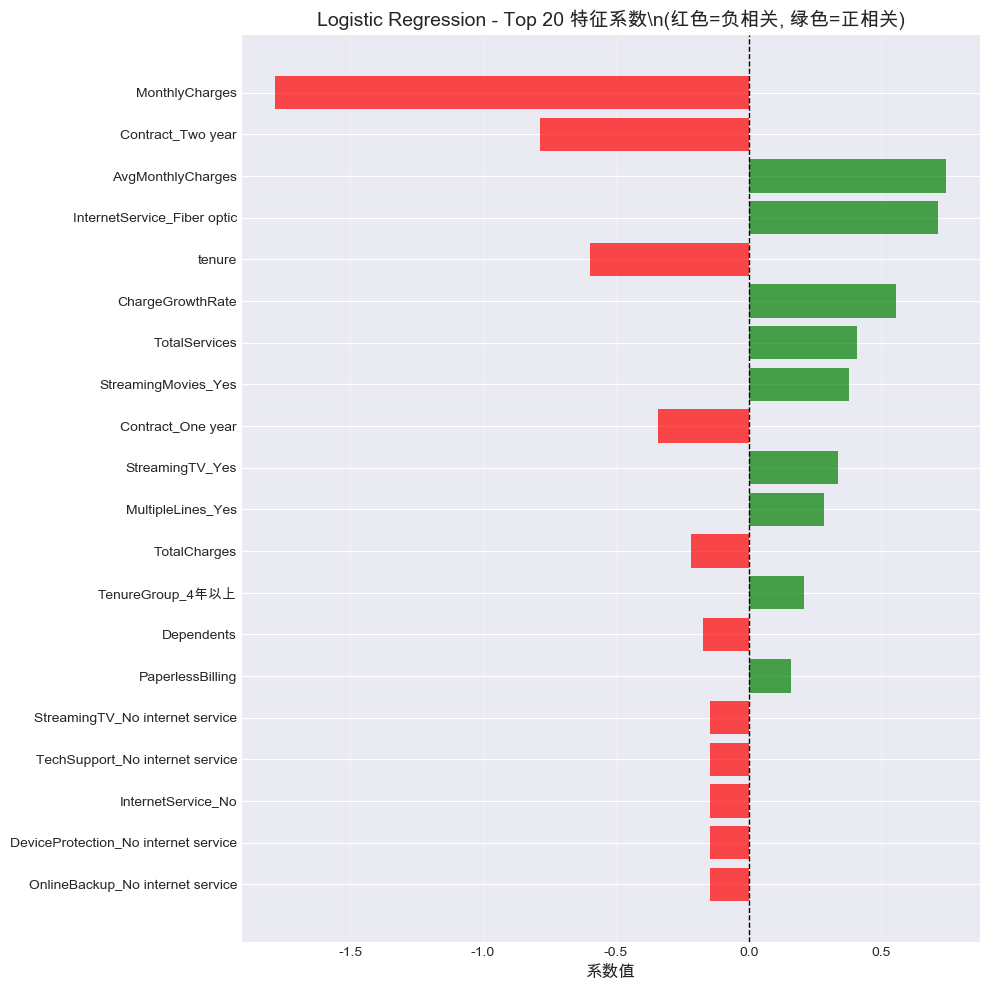


✅ 特征重要性分析完成


In [32]:
# 获取特征重要性
print(f"分析 {final_model_name} 的特征重要性...\n")

if hasattr(final_model, 'feature_importances_'):
    # 树模型有feature_importances_属性
    importances = final_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 20 最重要特征:")
    print("="*60)
    display(feature_importance_df.head(20))
    
    # 可视化Top 20特征
    plt.figure(figsize=(10, 10))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'].values, color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'].values, fontsize=10)
    plt.xlabel('重要性分数', fontsize=12)
    plt.title(f'{final_model_name} - Top 20 特征重要性', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 业务洞察
    print("\n🔍 关键业务洞察:")
    print("="*60)
    print("最重要的5个特征:")
    for i, row in feature_importance_df.head(5).iterrows():
        print(f"  {i+1}. {row['Feature']:30s} - 重要性: {row['Importance']:.4f}")
    
elif hasattr(final_model, 'coef_'):
    # 线性模型有coef_属性
    coefficients = final_model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("Top 20 最重要特征 (按系数绝对值):")
    print("="*60)
    display(feature_importance_df.head(20))
    
    # 可视化
    plt.figure(figsize=(10, 10))
    top_20 = feature_importance_df.head(20)
    colors = ['red' if x < 0 else 'green' for x in top_20['Coefficient']]
    plt.barh(range(len(top_20)), top_20['Coefficient'].values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'].values, fontsize=10)
    plt.xlabel('系数值', fontsize=12)
    plt.title(f'{final_model_name} - Top 20 特征系数\\n(红色=负相关, 绿色=正相关)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 该模型不支持直接查看特征重要性")
    feature_importance_df = None

print("\n✅ 特征重要性分析完成")

### 9.2 测试集最终评估

在测试集上评估最终模型: Logistic Regression

测试集性能:
Accuracy:            0.7431
Precision:           0.5104
Recall:              0.7888
F1-Score:            0.6197
ROC-AUC:             0.8470

测试集混淆矩阵:


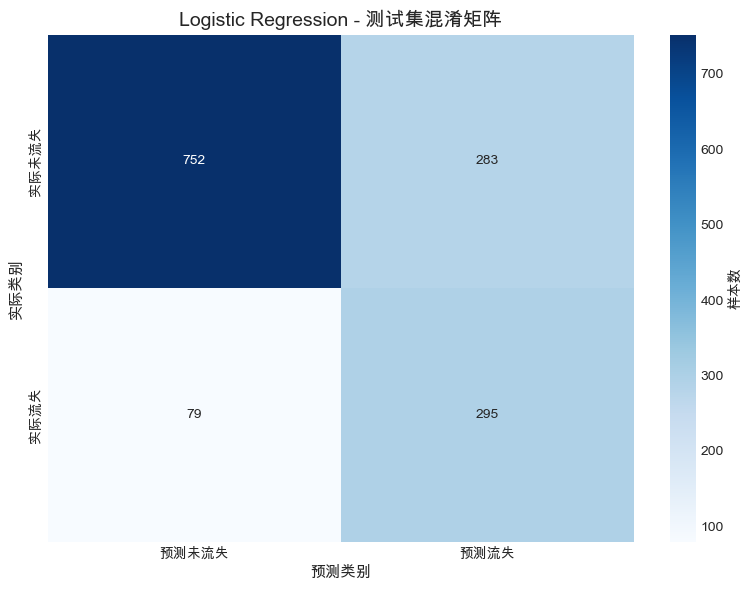


测试集分类报告:
              precision    recall  f1-score   support

         未流失       0.90      0.73      0.81      1035
          流失       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



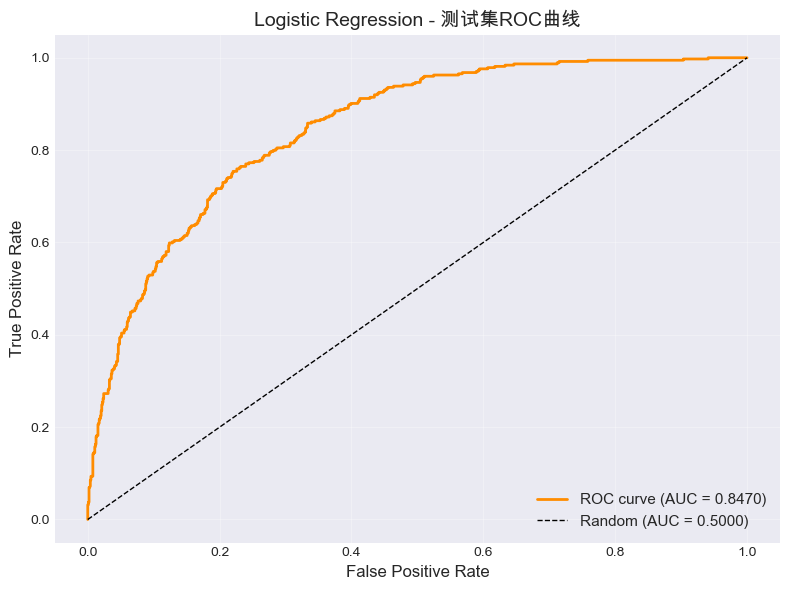


✅ 测试集评估完成


In [33]:
# 在测试集上评估最终模型
print(f"在测试集上评估最终模型: {final_model_name}\n")
print("="*80)

# 预测
y_test_pred = final_model.predict(X_test_scaled)
y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# 计算指标
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("测试集性能:")
print(f"{'Accuracy:':<20} {test_accuracy:.4f}")
print(f"{'Precision:':<20} {test_precision:.4f}")
print(f"{'Recall:':<20} {test_recall:.4f}")
print(f"{'F1-Score:':<20} {test_f1:.4f}")
print(f"{'ROC-AUC:':<20} {test_roc_auc:.4f}")

# 混淆矩阵
cm_test = confusion_matrix(y_test, y_test_pred)

print("\n测试集混淆矩阵:")
print("="*60)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测未流失', '预测流失'],
            yticklabels=['实际未流失', '实际流失'],
            cbar_kws={'label': '样本数'})
plt.title(f'{final_model_name} - 测试集混淆矩阵', fontsize=14, fontweight='bold')
plt.ylabel('实际类别', fontsize=11)
plt.xlabel('预测类别', fontsize=11)
plt.tight_layout()
plt.show()

# 分类报告
print("\n测试集分类报告:")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['未流失', '流失']))

# ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'{final_model_name} - 测试集ROC曲线', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ 测试集评估完成")

## 10. 模型保存与部署准备

### 10.1 保存模型和预处理器

In [34]:
# 创建models目录
import os
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"创建目录: {model_dir}/")

# 保存最终模型
model_path = f'{model_dir}/churn_model_final.pkl'
joblib.dump(final_model, model_path)
print(f"✅ 模型已保存: {model_path}")

# 保存数据预处理器
scaler_path = f'{model_dir}/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ 数据缩放器已保存: {scaler_path}")

# 保存特征列名
feature_names_path = f'{model_dir}/feature_names.pkl'
joblib.dump(list(X_train.columns), feature_names_path)
print(f"✅ 特征列名已保存: {feature_names_path}")

# 保存模型元信息
metadata = {
    'model_name': final_model_name,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'test_roc_auc': test_roc_auc,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(X_train.columns),
    'n_training_samples': len(X_train_balanced),
    'feature_names': list(X_train.columns)
}

metadata_path = f'{model_dir}/model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✅ 模型元信息已保存: {metadata_path}")

print("\n模型文件清单:")
print("="*60)
for file in os.listdir(model_dir):
    file_path = os.path.join(model_dir, file)
    file_size = os.path.getsize(file_path) / 1024  # KB
    print(f"  {file:30s} - {file_size:>8.2f} KB")

print("\n✅ 所有文件保存完成")

✅ 模型已保存: models/churn_model_final.pkl
✅ 数据缩放器已保存: models/scaler.pkl
✅ 特征列名已保存: models/feature_names.pkl
✅ 模型元信息已保存: models/model_metadata.pkl

模型文件清单:
  scaler.pkl                     -     2.68 KB
  churn_model_final.pkl          -     2.36 KB
  model_metadata.pkl             -     1.20 KB
  feature_names.pkl              -     0.83 KB

✅ 所有文件保存完成


### 10.2 创建预测函数（生产环境使用）

In [35]:
def predict_churn(customer_data, model_path='models/churn_model_final.pkl', 
                  scaler_path='models/scaler.pkl',
                  feature_names_path='models/feature_names.pkl'):
    """
    预测客户流失概率
    
    参数:
        customer_data: dict 或 DataFrame，包含客户特征
        model_path: 模型文件路径
        scaler_path: 缩放器文件路径
        feature_names_path: 特征名称文件路径
    
    返回:
        dict: 包含预测结果和概率
    """
    # 加载模型和预处理器
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    feature_names = joblib.load(feature_names_path)
    
    # 转换为DataFrame
    if isinstance(customer_data, dict):
        df = pd.DataFrame([customer_data])
    else:
        df = customer_data.copy()
    
    # 确保特征顺序一致
    df = df[feature_names]
    
    # 数据缩放
    df_scaled = scaler.transform(df)
    
    # 预测
    prediction = model.predict(df_scaled)
    probability = model.predict_proba(df_scaled)[:, 1]
    
    # 返回结果
    results = []
    for i in range(len(df)):
        results.append({
            'prediction': 'Churn' if prediction[i] == 1 else 'No Churn',
            'churn_probability': float(probability[i]),
            'confidence': float(max(probability[i], 1-probability[i]))
        })
    
    return results if len(results) > 1 else results[0]


# 测试预测函数
print("测试预测函数...\\n")

# 从测试集中随机选择3个样本
test_samples = X_test.sample(3, random_state=42)
test_samples_scaled = X_test_scaled.loc[test_samples.index]

print("预测示例:")
print("="*80)

for idx, (sample_idx, row) in enumerate(test_samples.iterrows(), 1):
    # 使用预测函数
    result = predict_churn(row.to_frame().T)
    
    # 实际标签
    actual_label = 'Churn' if y_test.loc[sample_idx] == 1 else 'No Churn'
    
    print(f"\\n样本 {idx}:")
    print(f"  实际标签:     {actual_label}")
    print(f"  预测结果:     {result['prediction']}")
    print(f"  流失概率:     {result['churn_probability']:.2%}")
    print(f"  预测置信度:   {result['confidence']:.2%}")
    print(f"  预测{'正确' if result['prediction'] == actual_label else '错误'}!")

print("\\n✅ 预测函数测试完成")

测试预测函数...\n
预测示例:
\n样本 1:
  实际标签:     No Churn
  预测结果:     No Churn
  流失概率:     37.18%
  预测置信度:   62.82%
  预测正确!
\n样本 2:
  实际标签:     No Churn
  预测结果:     Churn
  流失概率:     53.65%
  预测置信度:   53.65%
  预测错误!
\n样本 3:
  实际标签:     No Churn
  预测结果:     No Churn
  流失概率:     1.55%
  预测置信度:   98.45%
  预测正确!
\n✅ 预测函数测试完成


## 11. 项目总结与业务建议

### 11.1 项目成果总结

In [36]:
print("="*80)
print("🎯 客户流失预测项目 - 完整流程总结")
print("="*80)

print("\n📊 1. 数据集信息:")
print(f"   - 总样本数: {len(df):,}")
print(f"   - 特征数量: {df.shape[1]-1}")
print(f"   - 流失率: {df['Churn'].value_counts()['Yes']/len(df)*100:.2f}%")

print("\n🔧 2. 数据处理:")
print(f"   - 数据清洗: ✅ (处理缺失值、异常值)")
print(f"   - 特征编码: ✅ (Label Encoding + One-Hot Encoding)")
print(f"   - 特征工程: ✅ (创建{df_fe.shape[1] - df_encoded.shape[1]}个新特征)")
print(f"   - 特征缩放: ✅ (StandardScaler)")
print(f"   - 类别平衡: ✅ (SMOTE)")

print("\n🤖 3. 模型训练:")
print(f"   - 训练模型数: {len(models)}")
print(f"   - 模型列表: {', '.join(models.keys())}")

print("\n🏆 4. 最佳模型:")
print(f"   - 模型名称: {final_model_name}")
print(f"   - 测试集准确率: {test_accuracy:.4f}")
print(f"   - 测试集精确率: {test_precision:.4f}")
print(f"   - 测试集召回率: {test_recall:.4f}")
print(f"   - 测试集F1分数: {test_f1:.4f}")
print(f"   - 测试集ROC-AUC: {test_roc_auc:.4f}")

if feature_importance_df is not None:
    print("\n📈 5. 关键影响因素 (Top 5):")
    for i, row in feature_importance_df.head(5).iterrows():
        if 'Importance' in row:
            print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")
        else:
            print(f"   {i+1}. {row['Feature']}: {abs(row['Coefficient']):.4f}")

print("\n💾 6. 模型部署:")
print(f"   - 模型文件: ✅ 已保存到 models/")
print(f"   - 预测函数: ✅ predict_churn()")
print(f"   - 元信息: ✅ 已保存")

print("\n" + "="*80)
print("✅ 项目完成！模型已准备好用于生产环境部署")
print("="*80)

🎯 客户流失预测项目 - 完整流程总结

📊 1. 数据集信息:
   - 总样本数: 7,043
   - 特征数量: 20
   - 流失率: 26.54%

🔧 2. 数据处理:
   - 数据清洗: ✅ (处理缺失值、异常值)
   - 特征编码: ✅ (Label Encoding + One-Hot Encoding)
   - 特征工程: ✅ (创建6个新特征)
   - 特征缩放: ✅ (StandardScaler)
   - 类别平衡: ✅ (SMOTE)

🤖 3. 模型训练:
   - 训练模型数: 6
   - 模型列表: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM

🏆 4. 最佳模型:
   - 模型名称: Logistic Regression
   - 测试集准确率: 0.7431
   - 测试集精确率: 0.5104
   - 测试集召回率: 0.7888
   - 测试集F1分数: 0.6197
   - 测试集ROC-AUC: 0.8470

📈 5. 关键影响因素 (Top 5):
   8. MonthlyCharges: 1.7816
   27. Contract_Two year: 0.7872
   31. AvgMonthlyCharges: 0.7448
   12. InternetService_Fiber optic: 0.7118
   5. tenure: 0.5964

💾 6. 模型部署:
   - 模型文件: ✅ 已保存到 models/
   - 预测函数: ✅ predict_churn()
   - 元信息: ✅ 已保存

✅ 项目完成！模型已准备好用于生产环境部署


### 11.2 业务建议与行动方案

基于模型分析结果，以下是针对客户流失预防的业务建议：

#### 🎯 高风险客户识别策略

1. **重点关注特征** (基于特征重要性分析)
   - 关注在网时长短的客户（tenure < 12个月）
   - 监控月租费异常高的客户
   - 特别留意使用按月合同的客户

2. **客户分层管理**
   - **高风险客户** (流失概率 > 70%): 立即采取挽留措施
   - **中风险客户** (流失概率 40-70%): 定期关怀，优惠政策
   - **低风险客户** (流失概率 < 40%): 保持现有服务质量

#### 💡 挽留策略建议

1. **合同优化**
   - 鼓励按月合同用户转为年度合同
   - 提供长期合同折扣优惠
   - 合同到期前主动联系续约

2. **服务改进**
   - 加强技术支持服务
   - 提升在线安全和备份服务质量
   - 优化支付方式选择

3. **定价策略**
   - 对高风险客户提供个性化优惠
   - 调整月费用定价策略
   - 推出捆绑服务套餐

#### 📊 持续优化建议

1. **模型监控**
   - 定期(每月/季度)重新训练模型
   - 监控模型性能指标变化
   - 收集新数据更新特征工程

2. **A/B测试**
   - 测试不同挽留策略的效果
   - 比较模型预测与实际流失率
   - 优化挽留成本与效果平衡

3. **业务闭环**
   - 建立客户反馈机制
   - 跟踪挽留措施的实际效果
   - 将结果反馈到模型优化中

#### 🚀 下一步行动

1. **短期** (1-3个月)
   - 部署模型到生产环境
   - 对高风险客户实施挽留计划
   - 收集反馈数据

2. **中期** (3-6个月)
   - 评估挽留效果
   - 优化模型和策略
   - 扩大应用范围

3. **长期** (6-12个月)
   - 建立实时预警系统
   - 整合CRM系统自动化流程
   - 开发客户生命周期价值(CLV)模型

---

### 📚 参考资源

**数据集来源**
- Kaggle: Telco Customer Churn Dataset

**技术文档**
- Scikit-learn: https://scikit-learn.org/
- XGBoost: https://xgboost.readthedocs.io/
- LightGBM: https://lightgbm.readthedocs.io/
- Imbalanced-learn: https://imbalanced-learn.org/

**业务参考**
- Customer Churn Prediction Best Practices
- ROI Calculation for Churn Prevention
- Customer Retention Strategies

---

### 🎓 学习要点总结

本项目涵盖了完整的企业级机器学习流程：

1. ✅ **业务理解**: 明确问题定义和业务价值
2. ✅ **数据探索**: 全面的EDA，理解数据分布和特征关系
3. ✅ **数据预处理**: 缺失值处理、编码、缩放
4. ✅ **特征工程**: 创建有业务意义的新特征
5. ✅ **模型选择**: 对比多个算法，选择最优模型
6. ✅ **模型评估**: 使用多个指标全面评估
7. ✅ **模型优化**: 超参数调优提升性能
8. ✅ **模型解释**: 特征重要性，支持业务决策
9. ✅ **模型部署**: 保存模型，创建预测接口
10. ✅ **业务建议**: 将技术结果转化为可执行的业务策略

**与之前房价预测项目的区别：**
- 问题类型: 回归 → **分类**
- 评估指标: RMSE/R² → **ROC-AUC/F1/Precision/Recall**
- 类别平衡: 不需要 → **SMOTE处理**
- 业务应用: 价格预测 → **风险预警与决策支持**

---

**🎉 恭喜完成企业级客户流失预测项目！**